identify domains in 3-component system using Voronoi edge method to determine neighbors and Lo/Ld

then, find domain interface length from Voronoi edges

based off of registration fraction code

mdw 02/03/2017


In [395]:
from __future__ import print_function
%matplotlib inline
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
#import scipy.cluster.hierarchy
import scipy.spatial

In [396]:
traj=md.load('Rho=one_10us.xtc',top='Rho=one_10us.gro',stride=5)

In [397]:
name='1'

In [398]:
traj.n_frames

45

In [399]:
topology=traj.topology
allhead=topology.select('name PO4 or name ROH')

In [400]:
resnames=[atom.residue.name for atom in topology.atoms]
residue=[atom.residue for atom in topology.atoms]

In [401]:
#x,y coordinates of all for finding neighbors to determine local midplane z-value
# here, best to use xy radius of neighbors, since Voronoi across 2 leaflets could have complications

allheadxy=list([] for _ in xrange(traj.n_frames))
allheadz=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    for i in range(len(allhead)):
        allheadi=allhead[i]
        allheadxy[nn].append(traj.xyz[nn][allheadi][0:2:1])
        allheadz[nn].append(traj.xyz[nn][allheadi][2])


In [402]:
# mdtraj can't handle neighbors for gro (rather than xtc) inputs, so do it myself
#cutoffsq = 2.4**2; #square of maximum xy distance for neighbors
cutoffsq=1.0**2
neigh=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    neigh[nn]=list([] for _ in xrange(len(allhead)))
    for i in range(len(allheadxy[nn])):
        xyi=allheadxy[nn][i]
        for j in range(len(allhead)-i-1): #not self, but will add for midplane finding
            xyj=allheadxy[nn][j+i+1]
            distsq=(xyi[0]-xyj[0])**2 + (xyi[1]-xyj[1])**2
            if (distsq < cutoffsq):
                neigh[nn][i].append(j+i+1)
                neigh[nn][j+i+1].append(i)
  


In [403]:
#new leaflet id method based on tilt angles; PO4-C4A or ROH-C1 (both +6 beads)
num_head=len(allhead)
tiltvectors=list([] for _ in xrange(traj.n_frames))

for nn in range(traj.n_frames):
    tiltvectors[nn]=list([] for _ in xrange(num_head)) #store vector roh-c1 or po4-c4a
    
    for i in range(num_head):
        tiltvectors[nn][i]=traj.xyz[nn][allhead[i]]-traj.xyz[nn][allhead[i]+6]


In [404]:
# must fix periodic boundary condition errors in tiltvectors, then calculate tiltangle
norms=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    norms[nn]=list([] for _ in xrange(len(allhead)))
    halfx=0.5*traj.unitcell_lengths[nn][0]
    halfy=0.5*traj.unitcell_lengths[nn][1]
    halfz=0.5*traj.unitcell_lengths[nn][2]
    for i in range(len(allhead)):
        norms[nn][i]=np.linalg.norm(tiltvectors[nn][i])
        if (norms[nn][i] > halfz):
            if (np.abs(tiltvectors[nn][i][0]) > halfx):
                if (tiltvectors[nn][i][0]>0): 
                    tiltvectors[nn][i][0]=tiltvectors[nn][i][0]-2*halfx
                else:
                    tiltvectors[nn][i][0]=tiltvectors[nn][i][0]+2*halfx
            if (np.abs(tiltvectors[nn][i][1]) > halfy):
                if (tiltvectors[nn][i][1]>0): 
                    tiltvectors[nn][i][1]=tiltvectors[nn][i][1]-2*halfy
                else:
                    tiltvectors[nn][i][1]=tiltvectors[nn][i][1]+2*halfy
            if (np.abs(tiltvectors[nn][i][2]) > halfz):
                if (tiltvectors[nn][i][2]>0): 
                    tiltvectors[nn][i][2]=tiltvectors[nn][i][2]-2*halfz
                else:
                    tiltvectors[nn][i][2]=tiltvectors[nn][i][2]+2*halfz

    for i in range(len(allhead)):
        norms[nn][i]=np.linalg.norm(tiltvectors[nn][i])


In [405]:
# use neigh to find local average tilt vector, outliers are not in a leaflet
# if pointing neg in z, flip in x,y,z for making average in outer leaflet
localvector=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    localvector[nn]=list([] for _ in xrange(len(allhead)))
    for i in range(len(allhead)):
        localvectorsx=[]
        localvectorsy=[]
        localvectorsz=[]
        sgn=np.sign(tiltvectors[nn][i][2])
        localvectorsx.append(sgn*tiltvectors[nn][i][0]) #include self
        localvectorsy.append(sgn*tiltvectors[nn][i][1]) #include self
        localvectorsz.append(sgn*tiltvectors[nn][i][2]) #include self
        for j in range(len(neigh[nn][i])):
            sgn=np.sign(tiltvectors[nn][neigh[nn][i][j]][2])
            localvectorsx.append(sgn*tiltvectors[nn][neigh[nn][i][j]][0])
            localvectorsy.append(sgn*tiltvectors[nn][neigh[nn][i][j]][1])
            localvectorsz.append(sgn*tiltvectors[nn][neigh[nn][i][j]][2])
        localvector[nn][i]=[np.mean(localvectorsx),np.mean(localvectorsy),np.mean(localvectorsz)]
       

In [406]:
# find angle between orientation vector and local average orientation vector for each lipid
# in range [0,180]
diffangle=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    diffangle[nn]=list([] for _ in xrange(len(allhead)))
    for i in range(len(allhead)):
        normlv=np.linalg.norm(localvector[nn][i])
        normtv=np.linalg.norm(tiltvectors[nn][i])
        cos=np.dot(localvector[nn][i],tiltvectors[nn][i])/(normlv*normtv)
        if (cos==0):
            diffangle[nn][i]=90
        elif (cos==1 and np.sign(localvector[nn][i][2])==np.sign(tiltvectors[nn][i][2])):
            diffangle[nn][i]=0
        elif (cos==1 and np.sign(localvector[nn][i][2])==np.sign(tiltvectors[nn][i][2])):
            diffangle[nn][i]=180
        else:
            diffangle[nn][i]=np.arccos(cos)*180./np.pi


/Users/naveen/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in arccos


In [407]:
#have array with values placing each head in one leaflet: 0=lower, 1=upper, 2=between
head_leaflet=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    head_leaflet[nn]=list([] for _ in xrange(len(allhead)))
    for i in range(len(allhead)):
        if (diffangle[nn][i]>120):
            head_leaflet[nn][i]=0
        elif (diffangle[nn][i]<60):
            head_leaflet[nn][i]=1
        else:
            head_leaflet[nn][i]=2

In [408]:
# want to identify all midplane chol and remove all "midplane" phospholipids
# tilt angle insufficient
# chol: find distance from ROH to nearest PO4; if beyond threshold, then in midplane; 
# else, copy leaflet ID (do for all phospholipids); only if copying non-midplane

for nn in range(traj.n_frames):
    fixedchol=0
    fixedphos=0
    midplanechol=0
    for i in range(len(allhead)):
        mindist=100.0
        if (head_leaflet[nn][i]==2 and (not resnames[allhead[i]]=='CHOL')): #phospholipids, must assign
            for j in range(len(neigh[nn][i])):
                if (not resnames[allhead[neigh[nn][i][j]]]=='CHOL'):
                    dist=np.linalg.norm(traj.xyz[nn][allhead[i]]-traj.xyz[nn][allhead[neigh[nn][i][j]]])
                    if (dist < mindist and (not head_leaflet[nn][neigh[nn][i][j]]==2)):
                        mindist=dist
                        correct_leaflet=head_leaflet[nn][neigh[nn][i][j]]
            head_leaflet[nn][i]=correct_leaflet
            fixedphos=fixedphos+1
    #must fix all phospholipids before all chols, since some may use fixed phospholipid leaflet id
    # so, must go through allhead twice
    for i in range(len(allhead)):
        mindist=100.0
        if (resnames[allhead[i]]=='CHOL'): #all chol, ignoring angle
            for j in range(len(neigh[nn][i])):
                if (not resnames[allhead[neigh[nn][i][j]]]=='CHOL'):
                    dist=np.linalg.norm(traj.xyz[nn][allhead[i]]-traj.xyz[nn][allhead[neigh[nn][i][j]]])
                    if (dist < mindist and (not head_leaflet[nn][neigh[nn][i][j]]==2)):
                        mindist=dist
                        correct_leaflet=head_leaflet[nn][neigh[nn][i][j]]
            if (mindist<1.4): #close to a headgroup, so in a leaflet
                head_leaflet[nn][i]=correct_leaflet
                fixedchol=fixedchol+1
            else:
                head_leaflet[nn][i]=2
                midplanechol=midplanechol+1

In [409]:
# only need upper leaflet heads for this situation
upperheads=list([] for _ in xrange(traj.n_frames))
lowerheads=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
#    upperheads[nn]=[]
    for i in range(len(allhead)):
        if head_leaflet[nn][i]==1:
            upperheads[nn].append(allhead[i])
        if head_leaflet[nn][i]==0:
            lowerheads[nn].append(allhead[i])

In [410]:
#count DPPC as fraction of upper total, to find global concentration of DPPC
upperdppc=list([] for _ in xrange(traj.n_frames))
#uppertotal=list([] for _ in xrange(traj.n_frames))
globalconc=list([] for _ in xrange(traj.n_frames))

for nn in range(traj.n_frames):
    upperdppc[nn]=0
    for j in range(len(upperheads[nn])):
        if(resnames[upperheads[nn][j]]=='DXPC' or resnames[upperheads[nn][j]]=='DBPC' or resnames[upperheads[nn][j]]=='DPPC' or resnames[upperheads[nn][j]]=='CHOL'):
            upperdppc[nn]=upperdppc[nn]+1
    globalconc[nn]=float(upperdppc[nn])/len(upperheads[nn])

In [411]:
#x,y coordinates of outer for Voronoi
headxy=list([] for _ in xrange(traj.n_frames)) #[frame][head]
reg=list([] for _ in xrange(traj.n_frames))
frac_reg=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
#    headxy[nn]=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        upperheadsi=upperheads[nn][i]
        headxy[nn].append(traj.xyz[nn][upperheadsi][0:2:1])
        

    vor=scipy.spatial.Voronoi(np.array(headxy[nn]))

#Voronoi neighbors vneigh

#generate list of neighbors, edgeneigh
    edgeneigh=list([] for _ in xrange(len(upperheads[nn])))
    for k in range(len(vor.ridge_points)):
        pair=vor.ridge_points[k]
        edgeneigh[pair[0]].append(pair[1])
        edgeneigh[pair[1]].append(pair[0])



    vneigh=list([] for _ in xrange(len(upperheads[nn])))  #lipid type
    vneighres=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        vneighheads=edgeneigh[i] #upperhead index, not atom
        if not vneighheads:
            vneigh[i]=[]
            vneighres[i]=[]
        else:
            for j in range(len(vneighheads)):
                vneigh[i].append(resnames[upperheads[nn][vneighheads[j]]])
                vneighres[i].append(vneighheads[j])


#phase based on edges
    vphase=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        vneightot=1+len(vneigh[i]) #include self
        num_sat=0
        if (resnames[upperheads[nn][j]]=='DXPC' or resnames[upperheads[nn][j]]=='DBPC' or resnames[upperheads[nn][j]]=='DPPC' or resnames[upperheads[nn][j]]=='CHOL'):
            num_sat=num_sat+1
        for j in range(len(vneigh[i])):
            if (vneigh[i][j]=='DXPC' or vneigh[i][j]=='DBPC' or vneigh[i][j]=='DPPC' or vneigh[i][j]=='CHOL'):
                num_sat=num_sat+1
        vlocal_conc=float(num_sat)/vneightot #integer would always be zero
        if (vlocal_conc > globalconc[nn]):
            vphase[i] = 1 # Lo=1
        else:
            vphase[i] = 0 # Ld=0
        
#iterate edge-based phase determination to reduce small clusters
    vphase2=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        vneightot=1+len(vneigh[i])
        num_lo=0
        if (vphase[i]==1):
            num_lo=num_lo+1
        for j in range(len(vneigh[i])):
            if(vphase[vneighres[i][j]]==1):
                num_lo=num_lo+1
        vlocal_conc=float(num_lo)/vneightot
        if (vlocal_conc > 0.49):
            vphase2[i]=1
        else:
            vphase2[i]=0


#iterate edge-based phase determination to reduce small clusters
    vphase3=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        vneightot=1+len(vneigh[i])
        num_lo=0
        if (vphase2[i]==1):
            num_lo=num_lo+1
        for j in range(len(vneigh[i])):
            if(vphase2[vneighres[i][j]]==1):
                num_lo=num_lo+1
        vlocal_conc=float(num_lo)/vneightot
        if (vlocal_conc > 0.49):
            vphase3[i]=1
        else:
            vphase3[i]=0
            
            
# calculate opposite phase
    oppneigh=list([] for _ in xrange(len(upperheads[nn]))) #for upper, lower neighbors (xy dist)
    for i in range(len(upperheads[nn])):
        for j in range(len(neigh[nn][i])):
            if (head_leaflet[nn][neigh[nn][i][j]]==0): # if lower
                oppneigh[i].append(resnames[allhead[neigh[nn][i][j]]])
#           oppneighres[i].append(allhead[neigh[i][j]])

    oppphase=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        oppneightot=len(oppneigh[i])
        num_sat=0
        for j in range(len(oppneigh[i])):
            if (oppneigh[i][j]=='DXPC' or oppneigh[i][j]=='DBPC' or oppneigh[i][j]=='DPPC' or oppneigh[i][j]=='CHOL'):
                num_sat=num_sat+1
        if (oppneightot):
            local_conc=float(num_sat)/oppneightot
        else:
            local_conc=0
        if (local_conc > globalconc[nn]):
            oppphase[i] = 1 #Lo
        else:
            oppphase[i] = 0 #Ld
    

# for more logical comparison, iterate twice, using upper Voronoi neighbors' oppphase values
    oppphase2=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        vneightot=1+len(vneigh[i]) #include self, Voronoi same-leaflet neighbors
        num_lo=0
        if (oppphase[i]==0):
            num_lo=num_lo+1
        for j in range(len(vneigh[i])):
            if (oppphase[vneighres[i][j]]==1):
                num_lo=num_lo+1
        local_conc=float(num_lo)/vneightot
        if (local_conc > 0.49):
            oppphase2[i]=1
        else: 
            oppphase2[i]=0

    oppphase3=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        vneightot=1+len(vneigh[i]) #include self, Voronoi same-leaflet neighbors
        num_lo=0
        if (oppphase2[i]==0):
            num_lo=num_lo+1
        for j in range(len(vneigh[i])):
            if (oppphase2[vneighres[i][j]]==1):
                num_lo=num_lo+1
        local_conc=float(num_lo)/vneightot
        if (local_conc > 0.49):
            oppphase3[i]=1
        else: 
            oppphase3[i]=0
        
        
# compare oppphase3 to vphase3 to check for registration
    reg[nn]=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        if (oppphase3[i]==vphase3[i]):
            reg[nn][i]=1 # registered
        else:
            reg[nn][i]=0 # not registered
    frac_reg[nn]=float(sum(reg[nn]))/len(reg[nn])

In [412]:
#x,y coordinates of outer for Voronoi
headxy=list([] for _ in xrange(traj.n_frames)) #[frame][head]
intmember=list([] for _ in xrange(traj.n_frames))
intfrac=list([] for _ in xrange(traj.n_frames))
regintfrac=list([] for _ in xrange(traj.n_frames))
u_phase_global=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
#    headxy[nn]=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        upperheadsi=upperheads[nn][i]
        headxy[nn].append(traj.xyz[nn][upperheadsi][0:2:1])
        

    vor=scipy.spatial.Voronoi(np.array(headxy[nn]))

#Voronoi neighbors vneigh

#generate list of neighbors, edgeneigh
    edgeneigh=list([] for _ in xrange(len(upperheads[nn])))
    for k in range(len(vor.ridge_points)):
        pair=vor.ridge_points[k]
        edgeneigh[pair[0]].append(pair[1])
        edgeneigh[pair[1]].append(pair[0])



    vneigh=list([] for _ in xrange(len(upperheads[nn])))  #lipid type
    vneighres=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        vneighheads=edgeneigh[i] #upperhead index, not atom
        if not vneighheads:
            vneigh[i]=[]
            vneighres[i]=[]
        else:
            for j in range(len(vneighheads)):
                vneigh[i].append(resnames[upperheads[nn][vneighheads[j]]])
                vneighres[i].append(vneighheads[j])


#phase based on edges
    vphase=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        vneightot=1+len(vneigh[i]) #include self
        num_sat=0
        if (resnames[upperheads[nn][j]]=='DXPC' or resnames[upperheads[nn][j]]=='DBPC' or resnames[upperheads[nn][j]]=='DPPC' or resnames[upperheads[nn][j]]=='CHOL'):
            num_sat=num_sat+1
        for j in range(len(vneigh[i])):
            if (vneigh[i][j]=='DXPC' or vneigh[i][j]=='DBPC' or vneigh[i][j]=='DPPC' or vneigh[i][j]=='CHOL'):
                num_sat=num_sat+1
        vlocal_conc=float(num_sat)/vneightot #integer would always be zero
        if (vlocal_conc > globalconc[nn]):
            vphase[i] = 1 # Lo=1
        else:
            vphase[i] = 0 # Ld=0
        
#iterate edge-based phase determination to reduce small clusters
    vphase2=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        vneightot=1+len(vneigh[i])
        num_lo=0
        if (vphase[i]==1):
            num_lo=num_lo+1
        for j in range(len(vneigh[i])):
            if(vphase[vneighres[i][j]]==1):
                num_lo=num_lo+1
        vlocal_conc=float(num_lo)/vneightot
        if (vlocal_conc > 0.49):
            vphase2[i]=1
        else:
            vphase2[i]=0


#iterate edge-based phase determination to reduce small clusters
    vphase3=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        vneightot=1+len(vneigh[i])
        num_lo=0
        if (vphase2[i]==1):
            num_lo=num_lo+1
        for j in range(len(vneigh[i])):
            if(vphase2[vneighres[i][j]]==1):
                num_lo=num_lo+1
        vlocal_conc=float(num_lo)/vneightot
        if (vlocal_conc > 0.49):
            vphase3[i]=1
        else:
            vphase3[i]=0
            
#################################################################################
#ONLY GOING TO USE VPHASE TO CREAT U_PHASE
    domain=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])): #N: Cycling through all molecule heads
        domain[i]=0 # 0 = unassigned; N: Assigning each domain a value of 0

    recurlist=[] # list of heads that must run through domain algorithm because in chain of neighbors

    domain[0]=1 # first lipid sets first domain
    for i in range(len(vneighres[0])): # vneighres is allheadz index, not atom
        ni=vneighres[0][i] #N: Looking at specific patch
        if vphase[ni]==vphase[0]: #only neighbors in same phase; N: Check if they have the same phase
            domain[ni]=1
            recurlist.append(ni) #N: Add it the heads that need to be checked against their neighbors
    num_domains=1
    
    while len(recurlist): # no new domain should be introduced in this section
        headi=recurlist[0] #N: Looking at the first entry in recurlist
        neighi=vneighres[headi] #N: Finding its neighbors
        recurlist=recurlist[1:] # remove 1st element, now being handled
        for j in range(len(neighi)):#N: For all of its neighbors
            ni=neighi[j] 
            if (vphase[ni]==vphase[headi] and domain[ni]==0): #avoid infinitely putting back into recurlist; N: is the phase same as domian
                domain[ni]=domain[headi] #N: Domain is the same as the head
                recurlist.append(ni) #N: Put it back in the list to be checked again

    #now iterate over other lipids, excluding those already marked
    for i in range(len(upperheads[nn])-1): # 0 already done
        if domain[i+1]==0: #not yet marked
            neighi=vneighres[i+1]
            num_domains=num_domains+1
            domain[i+1]=num_domains
            for j in range(len(neighi)):
                ni=neighi[j]
                if vphase[ni]==vphase[i+1]:
                    domain[ni]=domain[i+1] 
                    recurlist.append(ni)
            while len(recurlist): #until exhausted, then move onto next new domain
                headi=recurlist[0]
                neighi=vneighres[headi]
                recurlist=recurlist[1:]
                for j in range(len(neighi)):
                    ni=neighi[j]
                    if (vphase[ni]==vphase[headi] and domain[ni]==0):
                        domain[ni]=domain[headi]
                        recurlist.append(ni)
                        
    # see how many lipids in each domain
    num_domains=max(domain)
    domainsize=list([] for _ in xrange(num_domains))
    for i in range(len(domainsize)):
        domainsize[i]=0
    for i in range(len(domain)):
        di=domain[i]-1 #return to 0-index
        domainsize[di]=domainsize[di]+1

    #N: Method to get rid of domains that are less than 10 lipids long. 1) Find domains which are less than 10 lipids 
    #N: 2) Take every lipid with a small domain and add it to a list 3) Take that list and change the phase, and make
    #N: an  updated phase list

    #N: Going to make a list of the domains which are too small
    small_domain=[]
    lipid_counter=0 #N: Total number of lipids 
    for i in range(len(domainsize)): 
        if domainsize[i]<10: 
            small_domain.append(i+1)
            lipid_counter=lipid_counter+domainsize[i]


    #N: Go through domain(holds which domain every lipid belongs to) and see if its domain is in small_domian
    #N: If it is, its phase needs to be changed 
    phase_req_change=[]
    for i in range(len(domain)):
        if domain[i] in small_domain:
            phase_req_change.append(i)

    #N: Go through phase_req_change. Each entry is the lipid whose phase needs to be switched. So take that entry
    #N: and plug it into u_phase. Then switch the value of u_phase.
    u_phase=[]

    for i in range(len(vphase)):
        if i in phase_req_change:
            #print(n)
            if vphase[i]==0:
                u_phase.append(1)
            if vphase[i]==1:
                u_phase.append(0)
        else: 
            u_phase.append(vphase[i])
    u_phase_global[nn]=u_phase
#############################################################

# find Voronoi edges that are domain edges as well
# find lipids that are "members" of the interface, i.e. have at least one edge on it
    regint=0
    intmember[nn]=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        vneightot=1+len(vneigh[i])
        num_lo=0
        if (u_phase[i]==1):
            num_lo=num_lo+1
        for j in range(len(vneigh[i])):
            if(u_phase[vneighres[i][j]]==1):
                num_lo=num_lo+1
        vlocal_conc=float(num_lo)/vneightot
        if (vlocal_conc==1 or vlocal_conc==0): #all same-phase neighbors
            intmember[nn][i]=0
        else: #not all neighbors belong to same phase
            intmember[nn][i]=1
            if (reg[nn][i]==1): #looking to see if int lipids are more often antiregistered
                regint=regint+1

    intfrac[nn]=float(sum(intmember[nn]))/len(intmember[nn])
    regintfrac[nn]=float(regint)/sum(intmember[nn]) #fraction of int lipids R, compare to overall
            
 

In [413]:
[np.mean(frac_reg),np.mean(frac_reg)]

[0.9259748048864367, 0.9259748048864367]

In [414]:
from scipy.optimize import curve_fit
def func(x,a,b):
    return a*np.exp(-x/b)

In [415]:
all_tau=[]
for i in range(1):
    input=np.array(intfrac)
    input=input-np.mean(input)
    result=np.correlate(input,input,mode='full')
    result=result[result.size//2:]
    #print(result[0])
    if (np.isfinite(result[0]/result[0])):
        result=result/result[0]
        popt,pcov=curve_fit(func,range(0,traj.n_frames,1),result[0:traj.n_frames])
        all_tau.append(popt)
np.max(all_tau)

1.0037178718510387

In [416]:
np.ceil(np.max(all_tau))
j=0 
new_intfrac=[]
while j<len(intfrac): 
    new_intfrac.append(intfrac[j])
    j=j+int(np.ceil(np.max(all_tau)))

In [417]:
np.mean(new_intfrac)

0.12141963588390522

In [418]:
np.std(new_intfrac)/len(new_intfrac)**.5

0.0011696789930441965

In [419]:
len(new_intfrac)

23

In [420]:
file=open('Sym_Interface_Length_Data.txt',"a")

file.write(name)
file.write("  ")
file.write(str(np.mean(new_intfrac)))
file.write("  ")
file.write(str(np.mean(np.std(new_intfrac))/(len(new_intfrac)**.5)))
    
file.write("\n")


In [421]:
file=open('Sym_Int_Length_Raw_Data{}.txt'.format(name),"a")

file.write(name)
file.write("  ")
for i in new_intfrac:
    file.write(str(i))
    file.write(",")    
file.write("\n")

In [422]:
all_tau=[]
for i in range(1):
    input=np.array(frac_reg)
    input=input-np.mean(input)
    result=np.correlate(input,input,mode='full')
    result=result[result.size//2:]
    #print(result[0])
    if (np.isfinite(result[0]/result[0])):
        print(len(result))
        result=result/result[0]
        popt,pcov=curve_fit(func,range(0,traj.n_frames,1),result[0:traj.n_frames])
        all_tau.append(popt)
np.max(all_tau)

45


4.81283231878017

In [423]:
np.ceil(np.max(all_tau))
new_fracreg=[]
j=0 
while j<len(frac_reg): 
    new_fracreg.append(frac_reg[j])
    j=j+int(np.ceil(np.max(all_tau)))

In [424]:
new_fracreg

[0.9249049429657795,
 0.9450286806883366,
 0.9367816091954023,
 0.9248444231689804,
 0.9215406562054208,
 0.9280643634642688,
 0.9146110056925996,
 0.910942681193747,
 0.9319695528068506]

In [425]:
np.std(new_fracreg)


0.00997018555279971

In [426]:
np.mean(new_fracreg)

0.9265208794868206

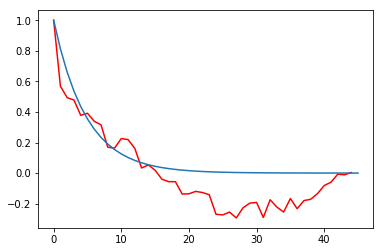

In [427]:
plt.plot(result,'r')
plt.plot(np.linspace(0,traj.n_frames,traj.n_frames+1), np.exp((-1./popt[-1])*np.linspace(0,traj.n_frames,traj.n_frames+1)))
plt.savefig('p20_autocorr.pdf',format='pdf')

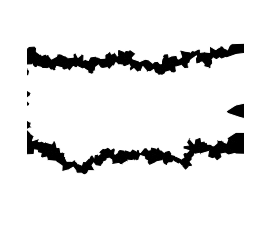

In [428]:
#plot reg vs antireg
# color Voronoi polygons
fig,ax=plt.subplots(1)
patches=[]
cmap=plt.get_cmap('gray_r')
#flatphase=[val for sublist in cphase for val in sublist]
#colors=cmap([x*10 for x in flatphase])
colors=cmap([(x*256) for x in intmember[-1]])
#for region in range(len(vor.regions)):
#    if not -1 in vor.regions[region]:
#        pg=Polygon(vor.vertices,closed=True)
#        patches.append(pg)




for i in range(len(vor.point_region)):
    verts=vor.regions[vor.point_region[i]] #indices of vertices forming that region
    if (verts==[]):
        pg=Polygon(np.array([[-1,-1],[-1.1,-1.1]]),closed=True)
        patches.append(pg)
    elif (not -1 in verts):
        vertcoord=list([] for _ in xrange(len(verts))) #coordinates of vertices
        for j in range(len(verts)):
            k=verts[j]
            vertcoord[j]=vor.vertices[k]
        pg=Polygon(vertcoord,closed=True)
        patches.append(pg)
    else:
        pg=Polygon(np.array([[-1,-1],[-1.1,-1.1]]),closed=True)
        patches.append(pg)
    



collection=PatchCollection(patches)
ax.add_collection(collection)
collection.set_color(colors)
        
#plt.fill(*zip(*pg))
ax.set_aspect('equal')
ax.set_xlim([0,36.5])
ax.set_ylim([0,36.5])

plt.axis('off')

plt.savefig('intf'+name+'.pdf',format='pdf')
plt.show()

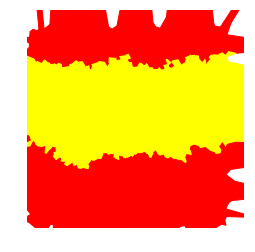

In [429]:
# color Voronoi polygons
#N: Make an updated picture of new phases
fig,ax=plt.subplots(1)
patches=[]
cmap=plt.get_cmap('autumn')
#flatphase=[val for sublist in cphase for val in sublist]
#colors=cmap([x*10 for x in flatphase])
colors=cmap([(x*256) for x in u_phase])
#for region in range(len(vor.regions)):
#    if not -1 in vor.regions[region]:
#        pg=Polygon(vor.vertices,closed=True)
#        patches.append(pg)




for i in range(len(vor.point_region)):
    verts=vor.regions[vor.point_region[i]] #indices of vertices forming that region
    if (verts==[]):
        pg=Polygon(np.array([[-1,-1],[-1.1,-1.1]]),closed=True)
        patches.append(pg)
    elif (not -1 in verts):
        vertcoord=list([] for _ in xrange(len(verts))) #coordinates of vertices
        for j in range(len(verts)):
            k=verts[j]
            vertcoord[j]=vor.vertices[k]
        pg=Polygon(vertcoord,closed=True)
        patches.append(pg)
    else:
        pg=Polygon(np.array([[-1,-1],[-1.1,-1.1]]),closed=True)
        patches.append(pg)
    



collection=PatchCollection(patches)
ax.add_collection(collection)
collection.set_color(colors)
        
#plt.fill(*zip(*pg))
ax.set_aspect('equal')
ax.set_xlim([0,36.5])
ax.set_ylim([0,36.5])

plt.axis('off')

plt.savefig(name+'.pdf',format='pdf')
plt.show()

In [430]:
file=open('Frac-Reg.txt',"a")

file.write(name)
file.write("  ")
file.write(str(np.mean(new_fracreg)))
file.write("  ")
file.write(str(np.mean(np.std(new_fracreg))/(len(new_intfrac)**.5)))
    
file.write("\n")


In [437]:
file=open('Frag_Reg_Raw_Data{}.txt'.format(name),"a")

file.write(name)
file.write("  ")
for i in new_fracreg:
    file.write(str(i))
    file.write(",")    
file.write("\n")